# RAF-DB - all classes
**Author**: Johannes S. Fischer

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

In [128]:
model_name = 'RAF-bias-african-american'

Load pretrained model to fine-tune it? If yes, specify model name, if no set it to ```None```.

In [129]:
pretrained_model_name = None

# Data

## Preprocessing Function
Preprocessing function like for VGG16, where pixel values per channel are normalized to have zero mean (```tensorflow``` implementation can be found [here](https://github.com/keras-team/keras/blob/2c48a3b38b6b6139be2da501982fd2f61d7d48fe/keras/applications/imagenet_utils.py#L168)).

In [130]:
# RAF-DB training data mean and std
mean = [146.6770, 114.6274, 102.3102]
std = None # [67.6282, 61.7651, 61.3665]

def preprocess(x):
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

def de_preprocess(x):
    if std is not None:
        x[..., 0] *= std[0]
        x[..., 1] *= std[1]
        x[..., 2] *= std[2]
    # normalize
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    return x.astype('uint8')

## Load Data

In [131]:
%%time

from utils.Dataloader import load_biased_RAF_targetvector

# settings
DATA_DIR = './data/biased/'

IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 64

# load data
train_ds, val_ds, test_ds = load_biased_RAF_targetvector(DATA_DIR,
                                                  target_img_size=IMG_SIZE,
                                                  image_dir_name='african-american/',  # change here
                                                  batch_size=BATCH_SIZE,
                                                  preprocessing_function=preprocess)

Splitting testing dataset into stratified validation and training set
Training
- (968, 100, 100, 3) 
- (968, 7)
Validation
- (117, 100, 100, 3) 
- (117, 7)
Testing
- (117, 100, 100, 3) 
- (117, 7)
CPU times: user 215 ms, sys: 146 ms, total: 362 ms
Wall time: 473 ms


Prepare some function to get labels...

In [132]:
emotion_labels = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

num_classes = len(emotion_labels)
print("Number of classes: ", num_classes)

def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

Number of classes:  7


## Data Examples

Show some examples...

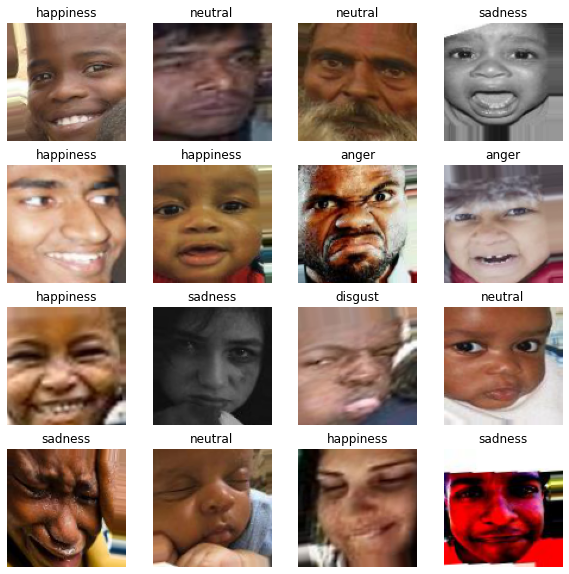

In [133]:
images, labels = next(train_ds)

plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(
        de_preprocess(images[i])
    )
    plt.title(vec2label(labels[i]))
    plt.axis('off')
plt.show()

# Model

## Base model
Architecture of the model without classification layer.

In [134]:
from utils.ModelGenerator import get_base_model2

# get base model
model = get_base_model2(IMG_SHAPE)

## Classification model
Add classification layer to the base model.

In [135]:
# add classification layer (softmax)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="softmax"))

# load pretrained version if required
if pretrained_model_name is not None:
    model.load_weights(f'./models/{pretrained_model_name}')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (ConvLayer)    (None, 100, 100, 64)      2048      
                                                                 
 block1_conv2 (ConvLayer)    (None, 100, 100, 64)      37184     
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 33, 33, 64)        0         
                                                                 
 block2_conv1 (ConvLayer)    (None, 33, 33, 96)        55776     
                                                                 
 block2_conv2 (ConvLayer)    (None, 33, 33, 96)        83424     
                                                                 
 block2_conv3 (ConvLayer)    (None, 33, 33, 96)        83424     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 11, 11, 96)       

# Training

In [136]:
# callbacks
dt = datetime.now().strftime("%m%d-%H%M")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"./modelcheckpoints/{model_name}_{dt}",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=4,
                                         verbose=1,
                                         mode='auto',
                                         min_lr=0.00000001),
    tf.keras.callbacks.CSVLogger(f'./modelcheckpoints/log/{model_name}_{dt}.csv',
                                 separator=",", append=True)
]

In [137]:
%%time

epochs = 30

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/30


2022-02-03 16:04:46.542678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 1.6659 - accuracy: 0.3667

2022-02-03 16:04:53.875781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_accuracy improved from -inf to 0.06838, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 9s 540ms/step - loss: 1.6659 - accuracy: 0.3667 - val_loss: 32.8879 - val_accuracy: 0.0684 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 1.4868 - accuracy: 0.4380
Epoch 00002: val_accuracy did not improve from 0.06838
16/16 [==============================] - 6s 357ms/step - loss: 1.4868 - accuracy: 0.4380 - val_loss: 20.0906 - val_accuracy: 0.0513 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 1.4515 - accuracy: 0.4483
Epoch 00003: val_accuracy improved from 0.06838 to 0.12821, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 455ms/step - loss: 1.4515 - accuracy: 0.4483 - val_loss: 4.5605 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss: 1.4019 - accuracy: 0.4866
Epoch 00004: val_accuracy improved from 0.12821 to 0.15385, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 452ms/step - loss: 1.4019 - accuracy: 0.4866 - val_loss: 7.8581 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - ETA: 0s - loss: 1.4201 - accuracy: 0.4618
Epoch 00005: val_accuracy improved from 0.15385 to 0.16239, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 439ms/step - loss: 1.4201 - accuracy: 0.4618 - val_loss: 6.6413 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - ETA: 0s - loss: 1.3929 - accuracy: 0.4649
Epoch 00006: val_accuracy improved from 0.16239 to 0.33333, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 429ms/step - loss: 1.3929 - accuracy: 0.4649 - val_loss: 3.5494 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/30
16/16 [==============================] - ETA: 0s - loss: 1.3571 - accuracy: 0.5000
Epoch 00007: val_accuracy did not improve from 0.33333
16/16 [==============================] - 5s 334ms/step - loss: 1.3571 - accuracy: 0.5000 - val_loss: 2.2865 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 8/30
16/16 [==============================] - ETA: 0s - loss: 1.3304 - accuracy: 0.5165
Epoch 00008: val_accuracy did not improve from 0.33333
16/16 [==============================] - 5s 331ms/step - loss: 1.3304 - accuracy: 0.5165 - val_loss: 3.8896 - val_accuracy: 0.1966 - lr: 0.0010
Epoch 9/30
16/16 [==============================] - ETA: 0s - loss: 1.3258 - accuracy: 0.5124
Epoch 00009: val_accuracy did not improve from 0.33333
16/16 [==============================] - 5s 329ms/step - loss: 1.3258 - accuracy: 0.5124 - val_loss: 2.0503 - val_accurac

INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 412ms/step - loss: 1.3046 - accuracy: 0.5227 - val_loss: 2.3515 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 11/30
16/16 [==============================] - ETA: 0s - loss: 1.2652 - accuracy: 0.5692
Epoch 00011: val_accuracy did not improve from 0.35897
16/16 [==============================] - 5s 335ms/step - loss: 1.2652 - accuracy: 0.5692 - val_loss: 1.9259 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 12/30
16/16 [==============================] - ETA: 0s - loss: 1.2339 - accuracy: 0.5837
Epoch 00012: val_accuracy did not improve from 0.35897
16/16 [==============================] - 5s 331ms/step - loss: 1.2339 - accuracy: 0.5837 - val_loss: 3.1052 - val_accuracy: 0.1709 - lr: 0.0010
Epoch 13/30
16/16 [==============================] - ETA: 0s - loss: 1.2551 - accuracy: 0.5713
Epoch 00013: val_accuracy did not improve from 0.35897
16/16 [==============================] - 5s 333ms/step - loss: 1.2551 - accuracy: 0.5713 - val_loss: 1.8957 - val_accu

INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 412ms/step - loss: 1.1916 - accuracy: 0.6126 - val_loss: 1.5328 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 16/30
16/16 [==============================] - ETA: 0s - loss: 1.1433 - accuracy: 0.6426
Epoch 00016: val_accuracy did not improve from 0.52137
16/16 [==============================] - 5s 333ms/step - loss: 1.1433 - accuracy: 0.6426 - val_loss: 1.5558 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 17/30
16/16 [==============================] - ETA: 0s - loss: 1.1830 - accuracy: 0.6333
Epoch 00017: val_accuracy did not improve from 0.52137
16/16 [==============================] - 5s 333ms/step - loss: 1.1830 - accuracy: 0.6333 - val_loss: 2.3556 - val_accuracy: 0.3248 - lr: 0.0010
Epoch 18/30
16/16 [==============================] - ETA: 0s - loss: 1.1661 - accuracy: 0.6405
Epoch 00018: val_accuracy improved from 0.52137 to 0.55556, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 425ms/step - loss: 1.1661 - accuracy: 0.6405 - val_loss: 1.5013 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 19/30
16/16 [==============================] - ETA: 0s - loss: 1.1262 - accuracy: 0.6343
Epoch 00019: val_accuracy did not improve from 0.55556
16/16 [==============================] - 5s 331ms/step - loss: 1.1262 - accuracy: 0.6343 - val_loss: 1.7270 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 20/30
16/16 [==============================] - ETA: 0s - loss: 1.0873 - accuracy: 0.6849
Epoch 00020: val_accuracy improved from 0.55556 to 0.60684, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 413ms/step - loss: 1.0873 - accuracy: 0.6849 - val_loss: 1.3727 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 21/30
16/16 [==============================] - ETA: 0s - loss: 1.0666 - accuracy: 0.6818
Epoch 00021: val_accuracy did not improve from 0.60684
16/16 [==============================] - 5s 327ms/step - loss: 1.0666 - accuracy: 0.6818 - val_loss: 1.3932 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 22/30
16/16 [==============================] - ETA: 0s - loss: 1.0691 - accuracy: 0.6963
Epoch 00022: val_accuracy did not improve from 0.60684
16/16 [==============================] - 5s 339ms/step - loss: 1.0691 - accuracy: 0.6963 - val_loss: 1.6501 - val_accuracy: 0.4359 - lr: 0.0010
Epoch 23/30
16/16 [==============================] - ETA: 0s - loss: 1.0494 - accuracy: 0.7035
Epoch 00023: val_accuracy improved from 0.60684 to 0.62393, saving model to ./modelcheckpoints/RAF-bias-african-american_0203-1604


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 431ms/step - loss: 1.0494 - accuracy: 0.7035 - val_loss: 1.1893 - val_accuracy: 0.6239 - lr: 0.0010
Epoch 24/30
16/16 [==============================] - ETA: 0s - loss: 1.0222 - accuracy: 0.7087
Epoch 00024: val_accuracy did not improve from 0.62393
16/16 [==============================] - 5s 335ms/step - loss: 1.0222 - accuracy: 0.7087 - val_loss: 1.2727 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 25/30
16/16 [==============================] - ETA: 0s - loss: 1.0133 - accuracy: 0.7324
Epoch 00025: val_accuracy did not improve from 0.62393
16/16 [==============================] - 5s 332ms/step - loss: 1.0133 - accuracy: 0.7324 - val_loss: 1.3579 - val_accuracy: 0.5470 - lr: 0.0010
Epoch 26/30
16/16 [==============================] - ETA: 0s - loss: 1.0042 - accuracy: 0.7304
Epoch 00026: val_accuracy did not improve from 0.62393
16/16 [==============================] - 5s 330ms/step - loss: 1.0042 - accuracy: 0.7304 - val_loss: 1.4445 - val_accu

INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias-african-american_0203-1604/assets


16/16 [==============================] - 7s 434ms/step - loss: 0.8990 - accuracy: 0.8079 - val_loss: 1.1962 - val_accuracy: 0.6667 - lr: 1.0000e-04
CPU times: user 1min 13s, sys: 29.3 s, total: 1min 42s
Wall time: 3min 1s


# Results

## Training Results

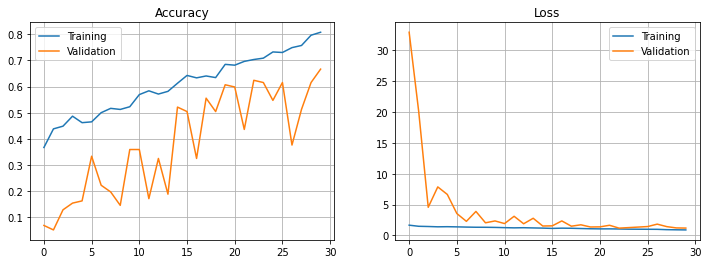

In [138]:
plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.grid(); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.grid(); plt.legend()
plt.show()

## Test Results

In [139]:
loss, acc = model.evaluate(test_ds, verbose=2)

print("\nAccuracy:\t%.2f%%" % (acc * 100))
print("Loss:\t\t%.4f" % (loss))

2/2 - 0s - loss: 1.2528 - accuracy: 0.5983 - 208ms/epoch - 104ms/step

Accuracy:	59.83%
Loss:		1.2528


# Save Model

In [140]:
if True:
    model.save_weights('./models/' + model_name + "_" + dt + '_weights.h5')
    model.save("./models/" + model_name + "_" + dt + "/")
    f = open("./models/info.txt", "a")
    txt = model_name + "_" + dt + " = " + str(np.max(history.history['val_accuracy'])*100) + "\n"
    f.write(txt)
    f.close()

INFO:tensorflow:Assets written to: ./models/RAF-bias-african-american_0203-1604/assets


INFO:tensorflow:Assets written to: ./models/RAF-bias-african-american_0203-1604/assets


---